In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import matplotlib.pyplot as plt
import netCDF4 as n
%matplotlib inline
from utils import train_test_split
import numpy as np

1.12.0


## Important parts of the code rely on the example found at tensorflow's  tutorial page:

https://www.tensorflow.org/tutorials/keras/basic_regression

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

## Import data

In [3]:
path = "./files/"
filenames = ["specific_humidity_Europa_sp.nc", "relative_humidity_Europa_sp.nc", "pressure_Europa_sp.nc",  
             "temperature_Europa_sp.nc", "total_cloud_cover_Europa_sp.nc"]


cloud = n.Dataset(path + filenames[-1], "r")
relative = n.Dataset(path + filenames[1], "r")
specific = n.Dataset(path + filenames[0], "r")
pressure = n.Dataset(path + filenames[2], "r")
temperature = n.Dataset(path + filenames[3], "r")

my_files = {'cloud':cloud, 'relative':relative, 'specific':specific, 'pressure':pressure, 'temperature':temperature}


tcc = cloud.variables["tcc"]
rh = relative.variables["r"]
q = specific.variables["q"]
sp = pressure.variables["sp"]
t2m = temperature.variables["t2m"]

my_vars = {'tcc':tcc, 'rh':rh, 'q':q, 'sp':sp, 't2m':t2m}

n_days = 7
n_grid_boxes = tcc.shape[1]*tcc.shape[2]
X = np.empty((n_grid_boxes*n_days*4, 4))
y = np.empty((n_grid_boxes*n_days*4))



for t in range(int(n_days*4)):
    i = 0
    for key, value in my_vars.items():
        if key == 'tcc':
            y[n_grid_boxes*t:n_grid_boxes*(t+1)] = np.array(value[t, : , :]).flatten()
        elif key == 'rh' or key == 'q':
            X[n_grid_boxes*t:n_grid_boxes*(t+1), i] = np.array(value[t, 0, : , :]).flatten()
            i = i+1
        else:
            X[n_grid_boxes*t:n_grid_boxes*(t+1), i] = np.array(value[t, : , :]).flatten()
            i=i+1

### Standarize and split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, split_size=0.2)

Xn_train = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
yn_train = (y_train - y_train.mean())/y_train.std()

Xn_test = (X_test - X_train.mean(axis=0))/X_train.std(axis=0)
yn_test = (y_test - y_train.mean())/y_train.std()

# Data frame

In [5]:
column_names = ['rh', 'q', 'sp', 't2m'] 

In [6]:
yn_train = yn_train.reshape(yn_train.shape[0], 1)
yn_test= yn_test.reshape(yn_test.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1)
yn_train.shape

(105213, 1)

In [7]:
dfXn_train=pd.DataFrame(Xn_train, columns=column_names) 
dfX_train=pd.DataFrame(X_train, columns=column_names) 
dfXn_train.head()

,rh,q,sp,t2m
0,-0.476627,-0.166940,-0.035202,0.209669
1,1.109921,-1.621238,0.330168,-2.958426
2,0.478049,-0.511113,-0.126838,-0.745832
3,-1.554792,0.768089,0.543273,1.695586
4,0.159366,0.156918,0.762367,0.134772


In [8]:
dfXn_test=pd.DataFrame(Xn_test, columns=column_names) 
dfXn_test.head()

,rh,q,sp,t2m
0,1.266652,-1.722921,0.536537,-3.055867
1,1.208685,-1.713032,0.535468,-2.987483
2,1.221460,-1.675734,0.519428,-2.661718
3,0.844260,-1.284159,0.494728,-1.403999
4,0.787804,-1.204619,0.487885,-1.273743


In [9]:
dfyn_train = pd.DataFrame(yn_train , columns=['tcc']) 
dfy_train = pd.DataFrame(y_train , columns=['tcc']) 
dfyn_train.head()

,tcc
0,-0.640933
1,-1.366202
2,0.446467
3,-0.192402
4,0.154116


In [10]:
dfyn_test = pd.DataFrame(yn_test , columns=['tcc']) 
dfyn_test.head()

,tcc
0,0.910738
1,0.910738
2,0.910822
3,0.910822
4,0.905548


In [11]:
df_train = pd.merge(dfyn_train, dfXn_train, left_index=True,right_index=True)
df_train.head()

,tcc,rh,q,sp,t2m
0,-0.640933,-0.476627,-0.166940,-0.035202,0.209669
1,-1.366202,1.109921,-1.621238,0.330168,-2.958426
2,0.446467,0.478049,-0.511113,-0.126838,-0.745832
3,-0.192402,-1.554792,0.768089,0.543273,1.695586
4,0.154116,0.159366,0.156918,0.762367,0.134772


In [12]:
df_test = pd.merge(dfyn_test, dfXn_test, left_index=True,right_index=True)
df_test.head()

,tcc,rh,q,sp,t2m
0,0.910738,1.266652,-1.722921,0.536537,-3.055867
1,0.910738,1.208685,-1.713032,0.535468,-2.987483
2,0.910822,1.221460,-1.675734,0.519428,-2.661718
3,0.910822,0.844260,-1.284159,0.494728,-1.403999
4,0.905548,0.787804,-1.204619,0.487885,-1.273743


In [13]:
df_t = pd.merge(dfy_train, dfX_train, left_index=True,right_index=True)
df_t.head()

,tcc,rh,q,sp,t2m
0,0.434331,70.956436,0.003877,98828.548251,278.963595
1,0.169945,94.393911,0.000991,100140.403316,255.260084
2,0.830727,85.059506,0.003194,98499.528705,271.814589
3,0.597836,55.029099,0.005732,100905.556123,290.081146
4,0.724154,80.351718,0.004519,101692.208458,278.403219


## clean data

In [14]:
df_train.isna().sum()

tcc    0
rh     0
q      0
sp     0
t2m    0
dtype: int64

In [15]:
# There is none nan in the data
# df_train = df_train.dropna()

In [16]:
df_test.isna().sum()

tcc    0
rh     0
q      0
sp     0
t2m    0
dtype: int64

In [17]:
# There is none nan in the data
# df_test = df_test.dropna()

## Inspect the data

C:\Users\nbpst2\Anaconda3\envs\tflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


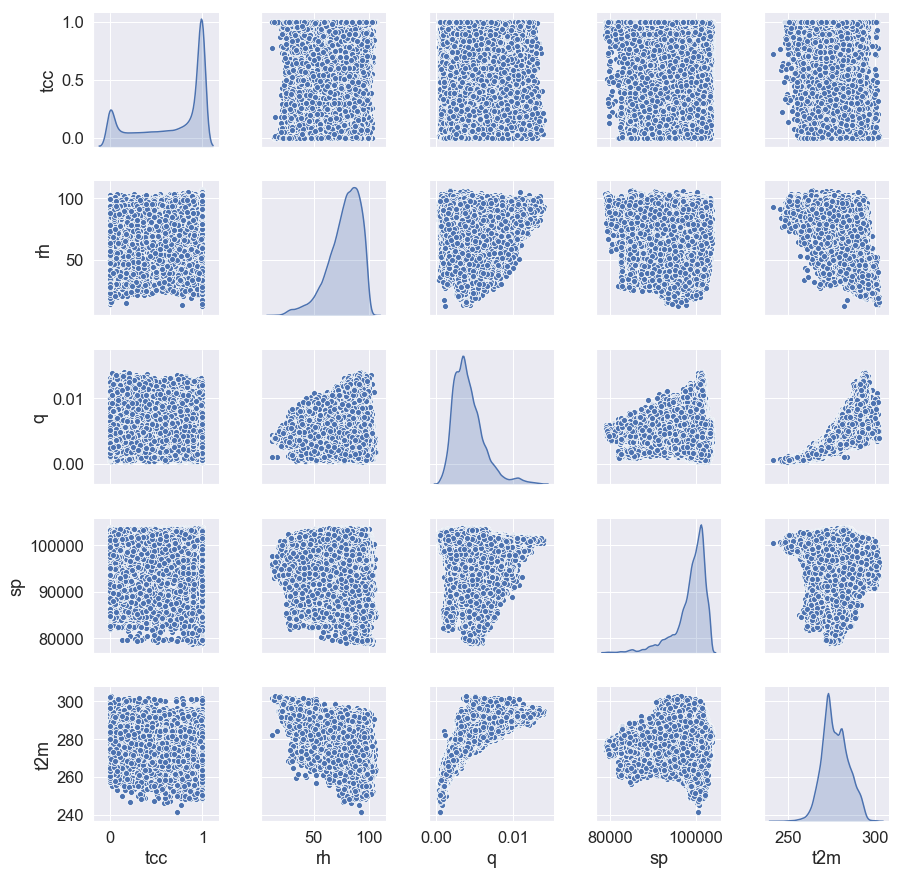

In [18]:
sns.set(font_scale=1.5)
sns.pairplot(df_t, diag_kind="kde")
#plt.savefig('results/inspection.png')

## Also look at the overall statistics:

In [19]:
train_stats = df_t.describe()
train_stats

,tcc,rh,q,sp,t2m
count,1.052130e+05,105213.000000,105213.000000,105213.000000,105213.000000
mean,6.679735e-01,77.997464,0.004208,98954.939436,277.394863
std,3.645368e-01,14.772700,0.001984,3590.506427,7.481980
min,9.998669e-13,11.883853,0.000306,78832.836422,241.299423
25%,3.542490e-01,69.889067,0.002796,97677.939639,272.173492
50%,8.397143e-01,80.609429,0.003847,99902.756759,276.761450
75%,9.966734e-01,89.130118,0.005195,101374.706515,282.538566
max,1.000000e+00,106.343980,0.013953,103829.875710,302.709274


# Build the model

In [20]:
# Define the R-squared metric
from keras import backend as K
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

Using TensorFlow backend.


## 2 layers

## Varying the optimizer using relu as activation

### RMSPropOptimizer

In [21]:
train_labels = df_train.pop('tcc')
test_labels = df_test.pop('tcc')

In [36]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(df_train.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [37]:
model = build_model()

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


#### Now try out the model. Take a batch of 10 exampes from the training data and call model.predict on it.

In [39]:
example_batch = df_train[:10]
example_result = model.predict(example_batch)
example_result

array([[0.08874224],
       [1.1166751 ],
       [0.30565536],
       [0.37399095],
       [0.20912567],
       [0.53063697],
       [0.44678754],
       [0.3407703 ],
       [0.33833787],
       [0.3508222 ]], dtype=float32)

#### Train the model
The model is trained for 1000 epochs, and record the training and validation accuracy in the history object

In [40]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  df_train, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Save the model

In [41]:
# Save entire model to a HDF5 file
model.save('keras_RMSPOpt0001_1000e_relu.h5')

#### Visualize the model's training progress using the stats stored in the history object.

In [42]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
995,0.591962,0.570061,0.591962,0.549852,0.566560,0.549852,995
996,0.556677,0.561732,0.556677,0.550233,0.566665,0.550233,996
997,0.567311,0.565573,0.567311,0.549896,0.566129,0.549896,997
998,0.578600,0.589162,0.578600,0.549368,0.566430,0.549368,998
999,0.559307,0.582777,0.559307,0.549884,0.566137,0.549884,999


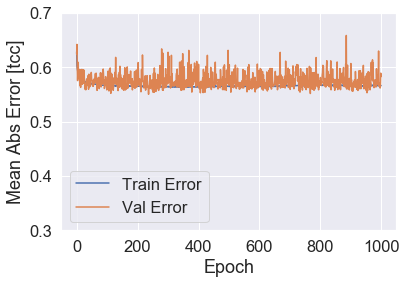

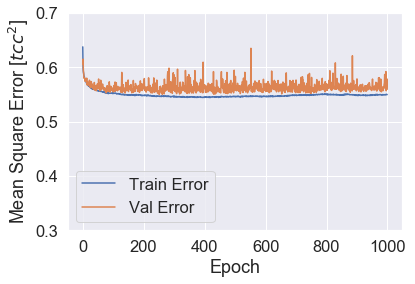

In [43]:
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [tcc]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0.3, 0.7])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$tcc^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()
  plt.ylim([0.3, 0.7])

plot_history(history)


....................................................................................................
...................................................

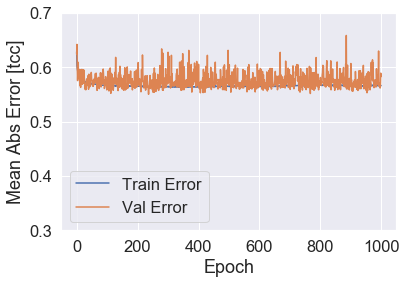

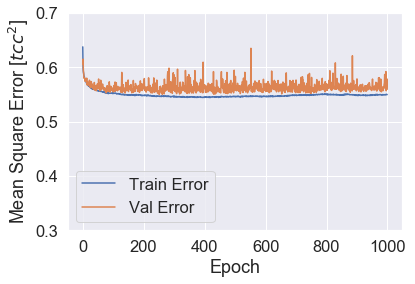

In [44]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(df_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

#### Let's see how did the model performs on the test set

In [45]:
loss, mae, mse = model.evaluate(df_test, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} tcc".format(mae))

Testing set Mean Abs Error:  0.56 tcc


#### Make predictions

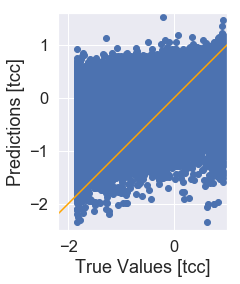

In [50]:
test_predictions = model.predict(df_test).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [tcc]')
plt.ylabel('Predictions [tcc]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-2.2, 1])
plt.ylim([-2.5,1.6])
_ = plt.plot([-100, 100], [-100, 100], c='orange')

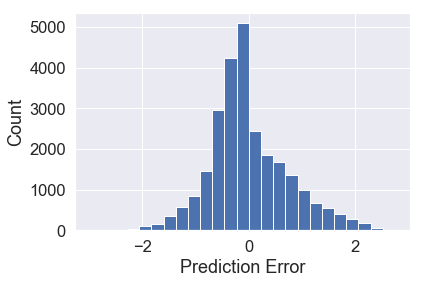

In [51]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [52]:
SS_res =  (( test_labels-test_predictions )**2).sum()
SS_tot = (( test_labels - (test_labels).mean() )**2 ).sum()
( 1 - SS_res/(SS_tot ))

0.444720925736769

In [49]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
146,0.560752,0.567481,0.560752,0.550142,0.565453,0.550142,146
147,0.565092,0.563159,0.565092,0.550123,0.565517,0.550123,147
148,0.567276,0.596424,0.567276,0.550380,0.565211,0.550380,148
149,0.559842,0.577222,0.559842,0.549860,0.565068,0.549860,149
150,0.557041,0.570347,0.557041,0.550439,0.565582,0.550439,150


##### 32 nodes - RMSPropOptimizer


....................................................................................................
....................................................................................................
...................

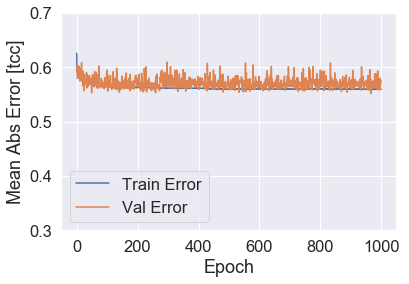

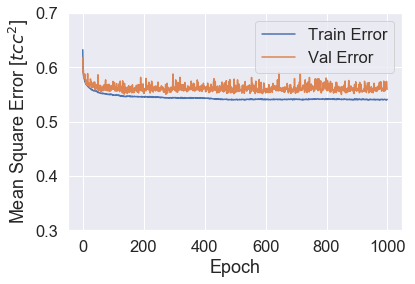

In [213]:
def build_model():
  model = keras.Sequential([
    layers.Dense(32, activation=tf.nn.relu, input_shape=[len(df_train.keys())]),
    layers.Dense(32, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(df_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [214]:
SS_res =  (( test_labels-test_predictions )**2).sum()
SS_tot = (( test_labels - (test_labels).mean() )**2 ).sum()
( 1 - SS_res/(SS_tot ))

0.4492509591709768

### Adam

In [196]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(df_train.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse', r_squared])
  return model


....................................................................................................
....................................................................................................
................

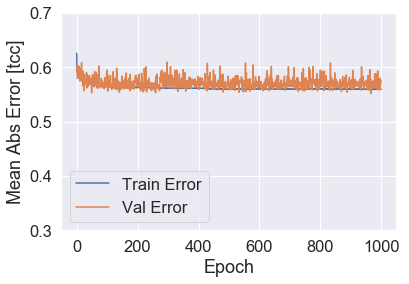

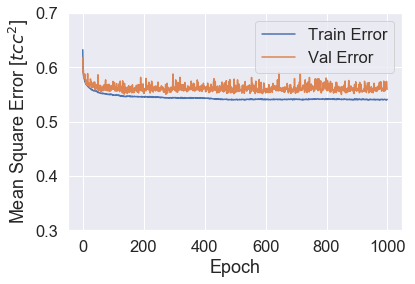

In [199]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(df_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

  
plot_history(history)

In [212]:
test_predictions = model.predict(df_test).flatten()
SS_res =  (( test_labels-test_predictions )**2).sum()
SS_tot = (( test_labels - (test_labels).mean() )**2 ).sum()
( 1 - SS_res/(SS_tot ))

0.4492509591709768

### SGD

In [193]:
from keras import optimizers
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(df_train.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  sgd = keras.optimizers.SGD(lr=0.01, nesterov=True)

  model.compile(loss='mse',
                optimizer=sgd,
                metrics=['mae', 'mse', r_squared])
  return model


....................................................................................................
....................................................................................................
....................................................................................................
.................................................................................

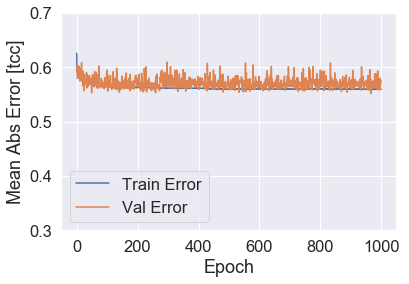

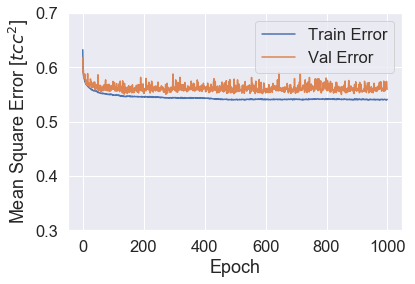

In [194]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(df_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

## Varying activation function using RMSPropOptimizer

#### Sigmoid


....................................................................................................
....................................................................................................
...............................................................................

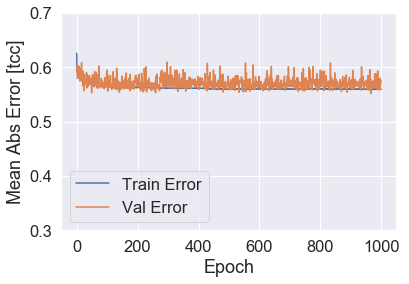

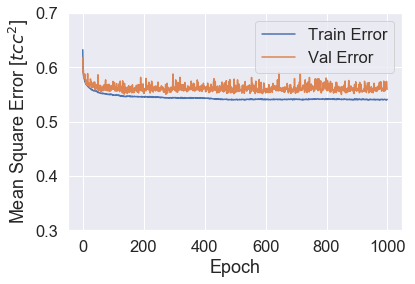

In [215]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.sigmoid, input_shape=[len(df_train.keys())]),
    layers.Dense(64, activation=tf.nn.sigmoid),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(df_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [217]:
test_predictions = model.predict(df_test).flatten()
SS_res =  (( test_labels-test_predictions )**2).sum()
SS_tot = (( test_labels - (test_labels).mean() )**2 ).sum()
( 1 - SS_res/(SS_tot ))

0.4345606774257924

##### elu


....................................................................................................
....................................................................................................
...................................

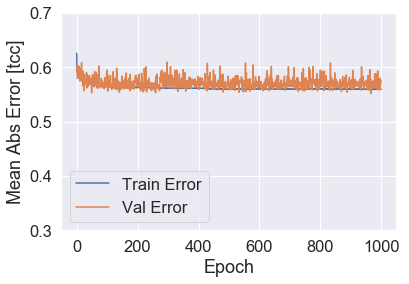

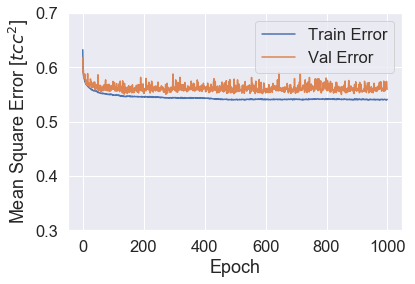

In [218]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.elu, input_shape=[len(df_train.keys())]),
    layers.Dense(64, activation=tf.nn.elu),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(df_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [219]:
test_predictions = model.predict(df_test).flatten()
SS_res =  (( test_labels-test_predictions )**2).sum()
SS_tot = (( test_labels - (test_labels).mean() )**2 ).sum()
( 1 - SS_res/(SS_tot ))

0.4181530214092478

## Vary number of layers

RMSPropOptimizer, 64 nodes, relu

### 1 hidden layer


....................................................................................................
....................................................................................................
....................................................................................................
.

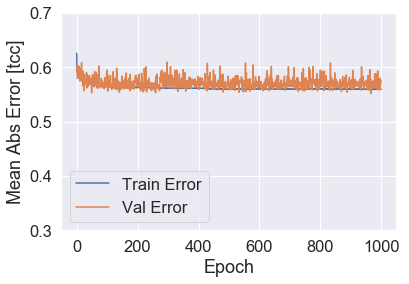

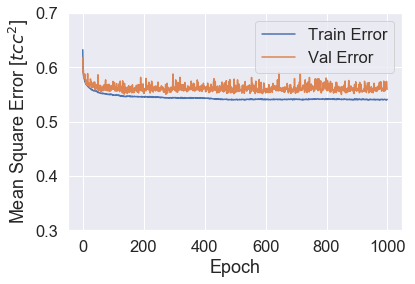

In [220]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(df_train.keys())]),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(df_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [221]:
test_predictions = model.predict(df_test).flatten()
SS_res =  (( test_labels-test_predictions )**2).sum()
SS_tot = (( test_labels - (test_labels).mean() )**2 ).sum()
( 1 - SS_res/(SS_tot ))

0.4140740674707635

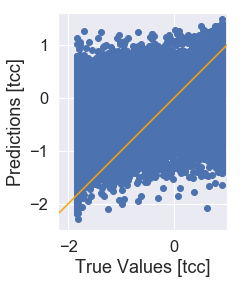

In [222]:
test_predictions = model.predict(df_test).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [tcc]')
plt.ylabel('Predictions [tcc]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-2.2, 1])
plt.ylim([-2.5,1.6])
_ = plt.plot([-100, 100], [-100, 100], c='orange')

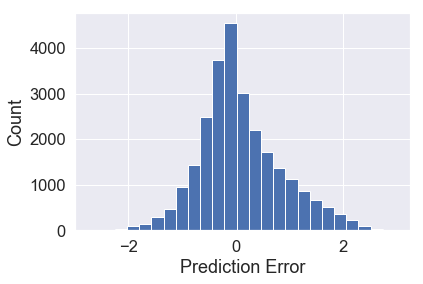

In [223]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [227]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
209,0.588287,0.579908,0.588287,0.574178,0.585614,0.574178,209
210,0.576921,0.600851,0.576921,0.574346,0.585327,0.574346,210
211,0.583218,0.588806,0.583218,0.573719,0.585318,0.573719,211
212,0.577335,0.585634,0.577335,0.574612,0.585184,0.574612,212
213,0.578952,0.584321,0.578952,0.574040,0.585356,0.574040,213


### 3 hidden layers


....................................................................................................
....................................................................................................
..................................................................

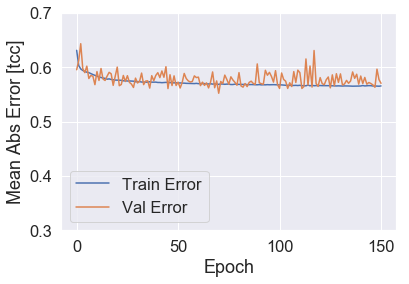

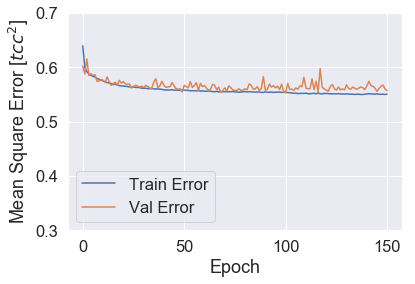

In [53]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(df_train.keys())]),
    layers.Dense(64, activation=tf.nn.elu),
    layers.Dense(64, activation=tf.nn.elu),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(df_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [54]:
test_predictions = model.predict(df_test).flatten()
SS_res =  (( test_labels-test_predictions )**2).sum()
SS_tot = (( test_labels - (test_labels).mean() )**2 ).sum()
( 1 - SS_res/(SS_tot ))

0.44307120529145194

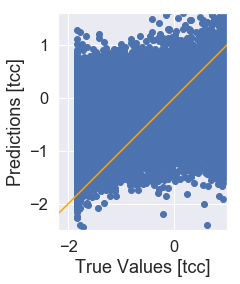

In [55]:
test_predictions = model.predict(df_test).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [tcc]')
plt.ylabel('Predictions [tcc]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-2.2, 1])
plt.ylim([-2.5,1.6])
_ = plt.plot([-100, 100], [-100, 100], c='orange')

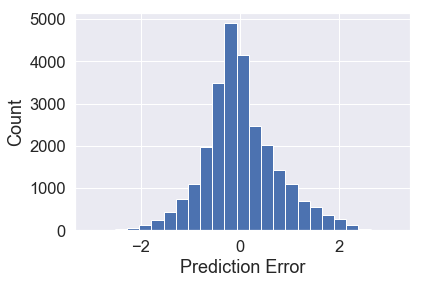

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [57]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
261,0.551216,0.570725,0.551216,0.541338,0.559289,0.541338,261
262,0.556701,0.568013,0.556701,0.540160,0.558543,0.540160,262
263,0.551512,0.555003,0.551512,0.541236,0.558651,0.541236,263
264,0.561986,0.587244,0.561986,0.540082,0.558301,0.540082,264
265,0.553623,0.560161,0.553623,0.541693,0.559035,0.541693,265


### 4 hidden layers


....................................................................................................
..................

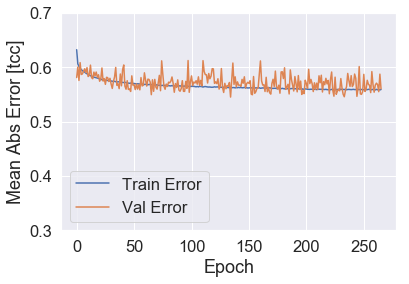

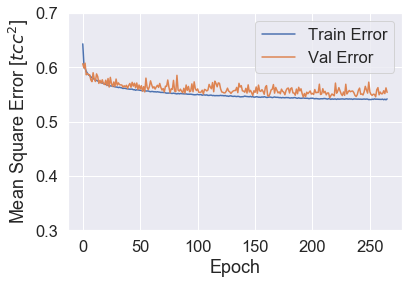

In [59]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(df_train.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(df_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [60]:
test_predictions = model.predict(df_test).flatten()
SS_res =  (( test_labels-test_predictions )**2).sum()
SS_tot = (( test_labels - (test_labels).mean() )**2 ).sum()
( 1 - SS_res/(SS_tot ))

0.4254927047619449

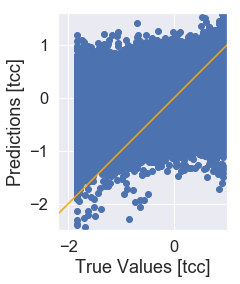

In [61]:
test_predictions = model.predict(df_test).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [tcc]')
plt.ylabel('Predictions [tcc]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-2.2, 1])
plt.ylim([-2.5,1.6])
_ = plt.plot([-100, 100], [-100, 100], c='orange')

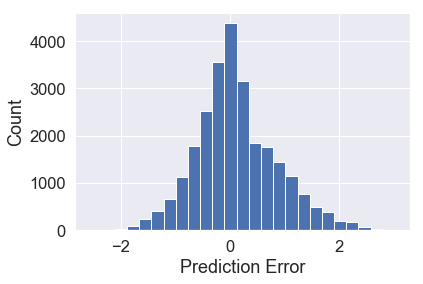

In [62]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [63]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
113,0.571556,0.561225,0.571556,0.551792,0.568909,0.551792,113
114,0.560763,0.569736,0.560763,0.552127,0.568830,0.552127,114
115,0.563799,0.581294,0.563799,0.551590,0.568417,0.551590,115
116,0.554473,0.577617,0.554473,0.552636,0.569120,0.552636,116
117,0.577635,0.574825,0.577635,0.552260,0.568301,0.552260,117
